In [59]:
import numpy as np
from pr3_utils import *
from scipy.linalg import expm
from tqdm import tqdm

In [60]:
filename = "../data/03.npz"
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)
t = np.squeeze(t)

Pose = np.zeros([3026,4,4]) # mu_t
Pose[:,0,0], Pose[:,1,1], Pose[:,2,2], Pose[:,3,3] = 1, 1, 1, 1

# PoseVar = np.diag([1e-1,1e-1,1e-1,1e-3,1e-3,1e-3])
PoseVar = np.eye(6)
PoseVar = np.repeat(PoseVar[np.newaxis,:,:], 3026, axis=0) #del_mu

NoiseCoVar = (1e-2)*np.identity(6) # W

tau = t - np.append(t[0],t[0:-1])
ut = np.vstack((linear_velocity,angular_velocity)).T
twist_t = axangle2twist(ut) # twist at time t
pose_increment = tau[:,np.newaxis,np.newaxis]*twist_t #Tau*ut(hat)
pose_increment = pose_increment.astype(np.double)


In [107]:
ut[2]

array([ 0.55, -0.02, -0.05, -0.02, -0.02,  0.01])

In [29]:
tau*twist_t

ValueError: operands could not be broadcast together with shapes (3026,) (3026,4,4) 

In [89]:
sd = -tau[:,None]*ut
sd[0].shape

(6,)

In [108]:
for i in range(1,5):
    Pose[i] = Pose[i-1]@expm(pose_increment[i])
    F = pose2adpose(axangle2pose(sd[i])) 
    print(F)
    print(ut[i])
    PoseVar[i] = pose2adpose(axangle2pose(sd[i]))@PoseVar[i-1]@pose2adpose(axangle2pose(sd[i])).T #+ NoiseCoVar

[[ 1.00e+00 -1.15e-03  1.14e-03  0.00e+00 -2.78e-03 -9.74e-04]
 [ 1.15e-03  1.00e+00 -3.94e-04  2.78e-03  0.00e+00  5.22e-02]
 [-1.14e-03  3.95e-04  1.00e+00  9.74e-04 -5.22e-02  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00 -1.15e-03  1.14e-03]
 [ 0.00e+00  0.00e+00  0.00e+00  1.15e-03  1.00e+00 -3.94e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.14e-03  3.95e-04  1.00e+00]]
[ 0.5   0.01 -0.03 -0.   -0.01 -0.01]
[[ 1.00e+00  6.03e-04  1.83e-03  0.00e+00 -4.80e-03  1.71e-03]
 [-6.00e-04  1.00e+00 -1.64e-03  4.80e-03  0.00e+00  5.80e-02]
 [-1.83e-03  1.64e-03  1.00e+00 -1.71e-03 -5.80e-02  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00  6.03e-04  1.83e-03]
 [ 0.00e+00  0.00e+00  0.00e+00 -6.00e-04  1.00e+00 -1.64e-03]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.83e-03  1.64e-03  1.00e+00]]
[ 0.55 -0.02 -0.05 -0.02 -0.02  0.01]
[[ 1.00e+00  2.15e-04  9.34e-04  0.00e+00 -2.42e-03  6.01e-04]
 [-2.14e-04  1.00e+00 -1.00e-03  2.42e-03  0.00e+00  6.55e-02]
 [-9.34e-04  1.00e-03  1.00e+00 -6.01e-0

In [100]:
print(F)

[[ 1.00e+00  1.22e-02 -4.46e-04  0.00e+00 -1.06e-02 -2.45e-03]
 [-1.22e-02  1.00e+00  3.91e-04  1.06e-02  0.00e+00  1.75e-01]
 [ 4.51e-04 -3.85e-04  1.00e+00  2.45e-03 -1.75e-01  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00  1.22e-02 -4.46e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.22e-02  1.00e+00  3.91e-04]
 [ 0.00e+00  0.00e+00  0.00e+00  4.51e-04 -3.85e-04  1.00e+00]]


In [51]:
np.min(PoseVar)

-1173.1030693885973

In [119]:
np.max(PoseVar)

895964.1952620312

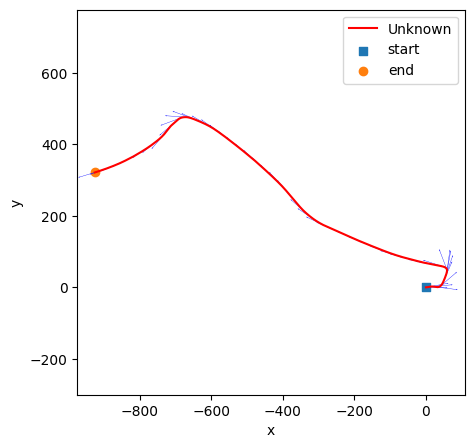

(<Figure size 500x500 with 1 Axes>, <AxesSubplot: xlabel='x', ylabel='y'>)

In [163]:
visualize_trajectory_2d(np.moveaxis(Pose[:1008],0,-1),show_ori=True)

In [5]:
Ks = np.zeros([4,4])
Ks[0:2,0:3] = K[0:2]
Ks[2,0:3] = K[0]
Ks[2,3] = -K[0,0]*b
Ks[3,0:3] = K[1]

cu,cv= Ks[0,2],Ks[1,2]
fsu,fsv = Ks[0,0],Ks[1,1]

def initialLandmarks(obs):
    uL,uR,vL,vR = obs[0],obs[1],obs[2],obs[3]
    z = fsu*b/(uL-vL)
    x = (uL-cu)*z/fsu
    y = (uR-cv)*z/fsv
    return np.stack((x,y,z,np.ones(x.shape)))

In [6]:
P = np.zeros([3,4])
P[:3,:3] = np.eye(3)
# sig = np.reshape(np.delete(map,3,axis=1),[13289*3,1])
# sig = np.cov(sig)

In [24]:
features20 = features[:,::20,:]
M = features20.shape[1]
mapDR = np.zeros([M,4])
map_vec = np.reshape(np.delete(mapDR,3,axis=1),[3*M,1])
zt = []
for t in tqdm(range(3026)):
    zt.append(np.squeeze(np.where(features20[0,:,t] != -1)))
    if(t==0):
        mcam = initialLandmarks(np.squeeze(features20[:,zt[0],0]))
        # map[zt[0]] = ((Pose[0]@inversePose(imu_T_cam)@mcam).T)
        mapDR[zt[0]] = ((Pose[0]@(imu_T_cam)@mcam).T)
        sig = 2*np.eye(M*3)
        continue

    new_ele = np.setdiff1d(zt[t],zt[t-1])
    # inter_ele = np.intersect1d(zt[t],zt[t-1])
    mcam = initialLandmarks(np.squeeze(features20[:,new_ele,t]))
    mapDR[new_ele] = ((Pose[t]@(imu_T_cam)@mcam).T)
    
    #Innovation
    obs1 = (Ks@(projection(((inversePose(imu_T_cam)@inversePose(Pose[t]))@(mapDR[zt[t]].T)).T).T))
    innovation = np.squeeze(features20[:,zt[t],t]) - obs1
    # print(innovation)
    Nt = np.size(zt[t])
    if(Nt == 1):
        continue
    # print(innovation)
    #Jacobian
    H = np.zeros([4*Nt,3*M])
    for i in range(Nt):
        index = zt[t][i]
        H[i*4:i*4+4,index*3:index*3+3] = Ks@projectionJacobian(inversePose(imu_T_cam)@inversePose(Pose[t])@(mapDR[zt[t][i]]))@inversePose(imu_T_cam)@inversePose(Pose[t])@(P.T)
    V = np.eye(4*Nt)*3

    #Update Step
    map_vec = np.reshape(mapDR[:,:-1], [3*M, 1])
    KalmanGain = sig@H.T@(np.linalg.inv(H@sig@H.T+V))
    sig = (np.eye(3*M) - KalmanGain@H)@sig
    map_vec = map_vec + np.einsum('ij,jk->ik', KalmanGain, np.reshape(innovation,[KalmanGain.shape[1],1]))
    mapDR[:,:-1] = np.reshape(map_vec, [M,3])

    

100%|██████████████████████████████████████| 3026/3026 [00:07<00:00, 431.18it/s]


(-800.0, 800.0)

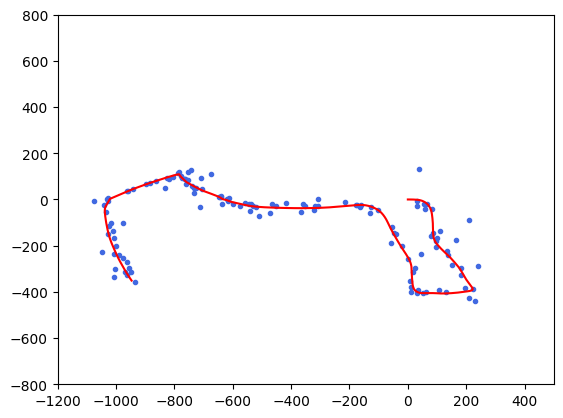

In [25]:
plt.scatter(mapDR[:,0],mapDR[:,1],marker='.',color='royalblue')
plt.plot(Pose[:,0,3],Pose[:,1,3],color='red')
plt.xlim([-1200,500])
plt.ylim([-800,800])
# plt.xlim([-1100,400])
# plt.ylim([-500,300])

### SLAM

Steps: 
1. Prediction:
    Part a; Modify the noise?
2. Update:
Use the predicted mean and variance as inputs to the update step
Calculate the Jacobian H wrt T i.e., $$\in$$ R (4N+1)*6
Use the Jacobian to compute Kalman Gain and then the others

In [7]:
def circleDot(mulm):
    out = np.zeros([4,6])
    out[:3,:3] = np.eye(3)
    out[:3,3:] = -axangle2skew(mulm[:3].T)
    return out

In [74]:
features.shape

(4, 5105, 1010)

In [79]:
featur20 = features[:,::20,:]
featur20[:,:5,0]

array([[164.79656982, 386.97143555, 641.29541016,  -1.        ,
         -1.        ],
       [ 31.38160515,  68.19519806, 272.61734009,  -1.        ,
         -1.        ],
       [155.08753967, 377.86401367, 608.78735352,  -1.        ,
         -1.        ],
       [ 31.67667389,  68.04985809, 272.41320801,  -1.        ,
         -1.        ]])

In [146]:
features20 = features[:,::20,:]
M = features20.shape[1]

PoseSL = np.zeros([3026,4,4],dtype=np.double)
PoseSL[0] = np.eye(4)

# PoseVarSL = np.diag([0.05,0.05,0.05,0.05,0.05,0.05])
PoseVarSL = 0.5*np.eye(6,dtype=np.double)
PoseVarSL = np.repeat(PoseVarSL[np.newaxis,:,:], 3026, axis=0) 
NoiseSL = (1e-3)*np.eye(6) # W
# NoiseSL = np.diag([1,1,1,1e-1,1e-1,1e-1])
NoiseSL = NoiseSL.astype(np.double)

SigmaSL = 2*np.eye(3*M + 6,dtype=np.double)
map = np.zeros([M,4],dtype=np.double)
map[:,3] = 1

#Landmarks at time t=0
zt = set()
zt.union(list(np.squeeze(np.where(features20[0,:,0] != -1))))
mcam = initialLandmarks(np.squeeze(features20[:,zt[0],0]))
mcam = mcam.astype(np.double)
map[zt[0]] = ((PoseSL[0]@(imu_T_cam)@mcam).T)
map_vec = np.reshape(np.delete(map,3,axis=1),[3*M,1]) #flattened world frame coordinates
map_vec = map_vec.astype(np.double)

cam_T_imu = inversePose(imu_T_cam)
cam_T_imu = cam_T_imu.astype(np.double)

for t in tqdm(range(1,5)):
    #Prediction Step
    PoseSL[t] = PoseSL[t-1]@expm(pose_increment[t])
    F = pose2adpose(axangle2pose(sd[t])) 

    print(ut[t])
   
    PoseVarSL[t] = F @PoseVarSL[t-1]@ F.T + NoiseSL
    # print(PoseSL[t])
    SigmaSL[-6:,-6:] = PoseVarSL[t]
    SigmaSL[:3*M,3*M:3*M+6] = SigmaSL[:3*M,3*M:3*M+6] @ F.T
    SigmaSL[3*M:,:3*M] = SigmaSL[:3*M,3*M:3*M+6].T 
    IPoset = inversePose(PoseSL[t])

    #Read valid indices
    zt.union(list(np.squeeze(np.where(features20[0,:,t] != -1))))
    # print(zt)
    Nt = np.size(zt[t])
    if(Nt == 1):
        continue

    # Landmark initialization
    new_ele = np.setdiff1d(zt[t],zt[t-1])
    inter_ele = np.intersect1d(zt[t],zt[t-1])
    mcam = initialLandmarks(np.squeeze(features20[:,new_ele,t]))
    Nt = np.size(inter_ele)
    # print(new_ele)
    # print(Nt)
    map[new_ele] = ((PoseSL[t]@(imu_T_cam)@mcam).T) 
    print(zt[t])
    ztold = zt[t][inter_ele]
    print(ztold)
    #Innovation
    # obs1 = (Ks@(projection(((inversePose(imu_T_cam)@inversePose(PoseSL[t]))@(map[zt[t]].T)).T).T))
    obs1 = Ks@(projection(((cam_T_imu @IPoset) @(map[zt[t]].T)).T).T)
    innovation = np.squeeze(features20[:,zt[t],t]) - obs1
    # print(innovation)
    #Jacobian
    H = np.zeros([4*Nt,3*M + 6])
    
    for i in range(Nt):
        index = ztold[i]
        # print(index)
        H[i*4:i*4+4,index*3:index*3+3] = Ks @projectionJacobian(cam_T_imu @ IPoset @ map[zt[t][i]]) @cam_T_imu @IPoset @(P.T)
        H[i*4:i*4+4,-6:] = -Ks @projectionJacobian(cam_T_imu @IPoset @map[zt[t][i]]) @cam_T_imu @circleDot(IPoset @map[zt[t][i]])
    # print(Nt)
    # print(H[:,-6:])
    # V = np.eye(4*Nt)*4

    # #Update Step
    # # print(KalmanGain.shape, SigmaSL.shape, H.shape)
    # map_vec = np.reshape(map[:,:-1], [3*M, 1])
    # if (np.linalg.det(H @ SigmaSL @H.T + V) == 0):
    #     continue
    # KalmanGainSL = SigmaSL @ H.T @ (np.linalg.inv(H @ SigmaSL @H.T + V)) 

    # # KalmanGain_pos = SigmaSL[-6:,-6:] @ H[:,-6:].T @ (np.linalg.inv(H[:,-6:] @ SigmaSL[-6:,-6:] @H[:,-6:].T + V)) 
    
    # SigmaSL = (np.eye(3*M + 6) - KalmanGainSL@H)@SigmaSL
    # PoseVarSL[t] = SigmaSL[-6:,-6:]
    # map_vec = map_vec + KalmanGainSL[:-6,:]@(np.reshape(innovation,[KalmanGainSL.shape[1],1]))
    # map = np.concatenate((np.reshape(map_vec,[M,3]),np.ones([M,1])),axis=1)
    # # print(map)
    
    # PoseSL[t] = PoseSL[t]@expm(axangle2twist((KalmanGainSL@np.reshape(innovation,KalmanGainSL.shape[1]))[-6:]))
    

0


TypeError: unhashable type: 'numpy.ndarray'

In [84]:
np.set_printoptions(2)
SigmaSL[-6:,-6:].T

array([[ 5.04e-01,  1.72e-04,  1.20e-04,  6.88e-06, -2.27e-03,  3.26e-03],
       [ 1.72e-04,  5.05e-01, -1.47e-05,  2.31e-03, -2.51e-05,  2.66e-02],
       [ 1.20e-04, -1.47e-05,  5.05e-01, -3.23e-03, -2.66e-02, -2.30e-05],
       [ 6.88e-06,  2.31e-03, -3.23e-03,  5.04e-01, -2.79e-17, -3.33e-17],
       [-2.27e-03, -2.51e-05, -2.66e-02, -2.79e-17,  5.04e-01, -2.75e-17],
       [ 3.26e-03,  2.66e-02, -2.30e-05, -3.31e-17, -2.75e-17,  5.04e-01]])

### Auxiliary Code

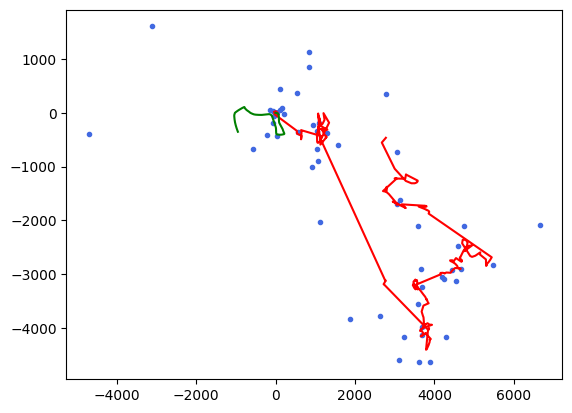

In [56]:
plt.scatter(map[:,0],map[:,1],marker='.',color='royalblue')
plt.plot(PoseSL[:,0,3],PoseSL[:,1,3],color='red')
plt.plot(Pose[:,0,3],Pose[:,1,3],color='green')
# plt.xlim([-1100,400])
# plt.ylim([-500,300])


In [103]:
test = (KalmanGain@np.reshape(innovation,KalmanGain.shape[1]))[-6:]
axangle2twist(test)

array([[ 0.00000000e+00, -8.36699122e-04, -8.43190098e-04,
        -3.90228132e-03],
       [ 8.36699122e-04,  0.00000000e+00,  1.71632154e-04,
         7.09355082e-04],
       [ 8.43190098e-04, -1.71632154e-04,  0.00000000e+00,
        -8.56505840e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [65]:
(pose2adpose(expm(-pose_increment[t]))@PoseVar[t-1]@pose2adpose(expm(-pose_increment[t])).T)

(6, 6)

In [29]:
# mapzx = np.zeros([features.shape[1],4])
# for t in range(3026):
#     idj = np.squeeze(np.where(features[0,:,t] != -1))
#     mcamzx = initialLandmarks(np.squeeze(features[:,idj,t]))
#     # print(inversePose(imu_T_cam)@mcamzx)
#     mapzx[idj] = (Pose[t]@(imu_T_cam)@mcamzx).T

In [44]:
# plt.scatter(mapzx[:,0],mapzx[:,1],marker='.',color='red')
# plt.plot(Pose[:,0,3],Pose[:,1,3])
# plt.xlim([-1200,500])
# plt.ylim([-500,200])

In [131]:
5374/6762 * 49514


39350.52292221236